In [1]:
%matplotlib inline
import matplotlib.image as mpimg
from statsmodels.api import Logit
import glob
import numpy as np
from numpy.random import default_rng
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import cv2
import joblib

In [2]:
paraTrain = glob.glob("Data/training_set/Parasitized/*")
noParaTrain = glob.glob("Data/training_set/Uninfected/*")
paraTest = glob.glob("Data/testing_set/Parasitized/*")
noParaTest = glob.glob("Data/testing_set/Uninfected/*")
paraValid = glob.glob("Data/validation_set/Parasitized/*")
noParaValid = glob.glob("Data/validation_set/Uninfected/*")

In [3]:
trainSize = 400
rng = default_rng()
paraTrainIndexes = rng.choice(len(paraTrain), trainSize,replace=False)
paraTrain = [mpimg.imread(paraTrain[i]) for i in paraTrainIndexes]
noParaTrainIndexes = rng.choice(len(noParaTrain), trainSize, replace=False)
noParaTrain = [mpimg.imread(noParaTrain[i]) for i in noParaTrainIndexes]
trainData = paraTrain + noParaTrain
trainLabels = [True]*trainSize + [False]*trainSize

validSize = 80
paraValidIndexes = rng.choice(len(paraValid), validSize, replace=False)
paraValid = [mpimg.imread(paraValid[i]) for i in paraValidIndexes]
noParaValidIndexes = rng.choice(len(noParaValid), validSize, replace=False)
noParaValid = [mpimg.imread(noParaValid[i]) for i in noParaValidIndexes]
validData = paraValid + noParaValid
validLabels = [True]*validSize + [False]*validSize

testSize = 80
paraTestIndexes = rng.choice(len(paraTest), testSize, replace=False)
paraTest = [mpimg.imread(paraTest[i]) for i in paraTestIndexes]
noParaTestIndexes = rng.choice(len(noParaTest), testSize, replace=False)
noParaTest = [mpimg.imread(noParaTest[i]) for i in noParaTestIndexes]
testData = paraTest + noParaTest
testLabels = [True]*testSize + [False]*testSize

In [4]:
trainHist = []
for i in trainData:
    flatImage = i.flatten()
    flatImage = flatImage[flatImage != 0]
    trainHist.append(np.histogram(flatImage, bins=20)
                     [0]/float(len(flatImage)))

validHist = []
for i in validData:
    flatImage = i.flatten()
    flatImage = flatImage[flatImage != 0]
    validHist.append(np.histogram(flatImage, bins=20)
                    [0]/float(len(flatImage)))

testHist = []
for i in testData:
    flatImage = i.flatten()
    flatImage = flatImage[flatImage != 0]
    testHist.append(np.histogram(flatImage, bins=20)
                    [0]/float(len(flatImage)))

In [5]:
logitModel = Logit(trainLabels, trainHist).fit()
pscore_logit = logitModel.predict(validHist)
joblib.dump(logitModel,'Models/logit_res.pkl')
logitModel.summary()

Optimization terminated successfully.
         Current function value: 0.197583
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      780
Method:                           MLE   Df Model:                           19
Date:                Wed, 01 Dec 2021   Pseudo R-squ.:                  0.7149
Time:                        12:04:23   Log-Likelihood:                -158.07
converged:                       True   LL-Null:                       -554.52
Covariance Type:            nonrobust   LLR p-value:                6.928e-156
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -39.7669     55.794     -0.713      0.476    -149.120      69.587
x2             0.5182     11.583      0.045      0.964     -22.184      23.221
x3            -4.1544      6.730     -0.617      0.537     -17.345       9.036
x4           -30.5180      8.133     -3.753      0.000     -46.458     -14.578
x5            16.1369      6.457      2.499      0.012       3.481      28.793
x6           -22.8042      6.638     -3.435      0.001     -35.815      -9.793
x7            -2.3131      4.139     -0.559      0.576     -10.426       5.799
x8            -8.0375      4.675     -1.719      0.086     -17.200       1.125
x9            -5.4761      4.177     -1.311      0.190     -13.664       2.712
x10           -0.6277      2.959     -0.212      0.832      -6.426       5.171
x11           -5.9950      2.196     -2.729      0.006     -10.300      -1.690
x12            7.3785      2.428      3.038      0.002       2.619      12.138
x13            1.2801      1.918      0.667      0.504      -2.479       5.039
x14            2.5816      2.244      1.150      0.250      -1.817       6.980
x15           -0.7526      2.357     -0.319      0.750      -5.373       3.868
x16            1.2862      2.202      0.584      0.559      -3.030       5.602
x17            6.9360      2.240      3.096      0.002       2.545      11.327
x18            4.2984      2.086      2.061      0.039       0.210       8.387
x19            4.4297      3.464      1.279      0.201      -2.359      11.219
x20           56.7828     26.631      2.132      0.033       4.587     108.979
==============================================================================
"""

In [6]:
pscore_knn = None
max_kscore_knn = 0
knnModel = None
for i in range(1, 22, 2):
    knnClas = KNeighborsClassifier(n_neighbors=i)
    knnClas.fit(trainHist, trainLabels)
    temp_pscore_knn = knnClas.predict_proba(validHist)
    fscore_knn = f1_score(testLabels, temp_pscore_knn[:, 1] > 0.5)
    if fscore_knn > max_kscore_knn:
        max_fscore_knn = fscore_knn
        pscore_knn = temp_pscore_knn
        knnModel = knnClas
joblib.dump(knnModel, 'Models/knnClas.pkl')

['Models/knnClas.pkl']

In [7]:
criterion = 'gini' #gini or entropy
max_features = 'sqrt' #sqrt || log2 || None
max_depth = None
randomForestClas = RandomForestClassifier(n_estimators=100,criterion=criterion,max_features=max_features,max_depth=max_depth)
randomForestClas.fit(trainHist, trainLabels)
pscore_forest = randomForestClas.predict_proba(validHist)
joblib.dump(randomForestClas, 'Models/randomForestClas.pkl')

['Models/randomForestClas.pkl']

-------------------->ROC<--------------------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.952
Random Forest: ROC AUC=0.966
KNN: ROC AUC=0.952
-------------------->Precision-Recall<--------------------
No Skill: Precision-Recall AUC=0.500
Logistic: Precision-Recall AUC=0.962
Random Forest: Precision-Recall AUC=0.974
KNN: Precision-Recall AUC=0.958


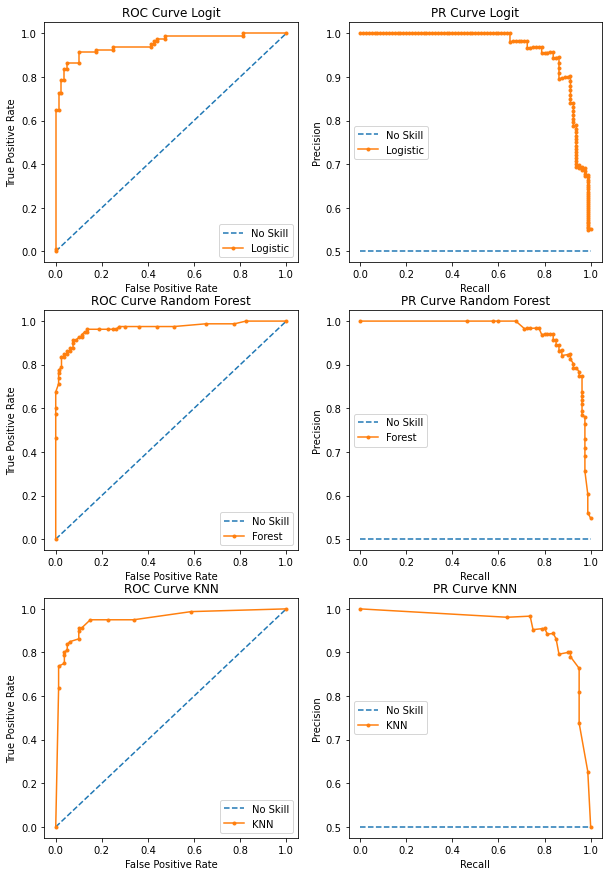

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

# generate a no skill prediction
ns_probs = [0 for _ in range(len(testLabels))]
no_skill = np.count_nonzero(testLabels) / len(testLabels)

# calculate curves
ns_fpr, ns_tpr, _ = roc_curve(testLabels, ns_probs)
logit_fpr, logit_tpr, _ = roc_curve(testLabels, pscore_logit)
forest_fpr, forest_tpr, _ = roc_curve(testLabels, pscore_forest[:, 1])
knn_fpr, knn_tpr, _ = roc_curve(testLabels, pscore_knn[:, 1])

ns_precision, ns_recall, _ = precision_recall_curve(testLabels, ns_probs)
logit_precision, logit_recall, _ = precision_recall_curve(
    testLabels, pscore_logit)
forest_precision, forest_recall, _ = precision_recall_curve(
    testLabels, pscore_forest[:, 1])
knn_precision, knn_recall, _ = precision_recall_curve(
    testLabels, pscore_knn[:, 1])


# calculate scores
ns_auc_roc = auc(ns_fpr, ns_tpr)
logit_auc_roc = auc(logit_fpr, logit_tpr)
forest_auc_roc = auc(forest_fpr, forest_tpr)
knn_auc_roc = auc(knn_fpr, knn_tpr)

ns_auc_pr = auc([0, 1], [no_skill, no_skill])
logit_auc_pr = auc(logit_recall, logit_precision)
forest_auc_pr = auc(forest_recall, forest_precision)
knn_auc_pr = auc(knn_recall, knn_precision)

# summarize scores
print("-------------------->ROC<--------------------")
print('No Skill: ROC AUC=%.3f' % (ns_auc_roc))
print('Logistic: ROC AUC=%.3f' % (logit_auc_roc))
print('Random Forest: ROC AUC=%.3f' % (forest_auc_roc))
print('KNN: ROC AUC=%.3f' % (knn_auc_roc))

print("-------------------->Precision-Recall<--------------------")
print('No Skill: Precision-Recall AUC=%.3f' % (ns_auc_pr))
print('Logistic: Precision-Recall AUC=%.3f' % (logit_auc_pr))
print('Random Forest: Precision-Recall AUC=%.3f' % (forest_auc_pr))
print('KNN: Precision-Recall AUC=%.3f' % (knn_auc_pr))


# plot the curve for the model
axs[0][0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs[0][0].plot(logit_fpr, logit_tpr, marker='.', label='Logistic')
axs[1][0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs[1][0].plot(forest_fpr, forest_tpr, marker='.', label='Forest')
axs[2][0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs[2][0].plot(knn_fpr, knn_tpr, marker='.', label='KNN')

axs[0][1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axs[0][1].plot(logit_recall, logit_precision, marker='.', label='Logistic')
axs[1][1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axs[1][1].plot(forest_recall, forest_precision, marker='.', label='Forest')
axs[2][1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axs[2][1].plot(knn_recall, knn_precision, marker='.', label='KNN')

# axis labels
plt.setp(axs[0][0], xlabel='False Positive Rate',
         ylabel='True Positive Rate', title="ROC Curve Logit")
plt.setp(axs[0][1], xlabel='Recall',
         ylabel='Precision', title="PR Curve Logit")
plt.setp(axs[1][0], xlabel='False Positive Rate',
         ylabel='True Positive Rate', title="ROC Curve Random Forest")
plt.setp(axs[1][1], xlabel='Recall',
         ylabel='Precision', title="PR Curve Random Forest")
plt.setp(axs[2][0], xlabel='False Positive Rate',
         ylabel='True Positive Rate', title="ROC Curve KNN")
plt.setp(axs[2][1], xlabel='Recall',
         ylabel='Precision', title="PR Curve KNN")

# show the legend
axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()
axs[1][1].legend()
axs[2][0].legend()
axs[2][1].legend()
